<a href="https://colab.research.google.com/github/MammadovN/Machine_Learning/blob/main/projects/05_time-series/stock-price-prediction/stock-price-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance pandas numpy scikit-learn statsmodels matplotlib tensorflow

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
ticker = "AAPL"
df = yf.download(ticker, start="2015-01-01", end="2025-01-01")[["Close"]].dropna()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
df["MA_10"] = df["Close"].rolling(window=10).mean()
df["MA_50"] = df["Close"].rolling(window=50).mean()
df["Return"] = df["Close"].pct_change()

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["RSI_14"] = compute_rsi(df["Close"])
df.dropna(inplace=True)

In [5]:
split_idx = int(len(df) * 0.8)
train_df, test_df = df[:split_idx], df[split_idx:]

In [6]:
arima_order = (5, 1, 0)
arima_model = ARIMA(train_df["Close"], order=arima_order).fit()
arima_pred = arima_model.forecast(steps=len(test_df))
mae_arima = mean_absolute_error(test_df["Close"], arima_pred)
rmse_arima = np.sqrt(mean_squared_error(test_df["Close"], arima_pred))
print(f"ARIMA MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA MAE: 57.7114, RMSE: 63.8429


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [7]:
features = ["Close", "MA_10", "MA_50", "Return", "RSI_14"]
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_df[features])
scaled_test  = scaler.transform(test_df[features])

def create_sequences(data, seq_length=20):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # predict 'Close'
    return np.array(X), np.array(y)

seq_length = 20
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test,  y_test  = create_sequences(scaled_test, seq_length)

In [8]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_error")
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[es]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0799 - val_loss: 0.0095
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0022 - val_loss: 0.0036
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
LSTM MAE: 10.0699, RMSE: 12.5250


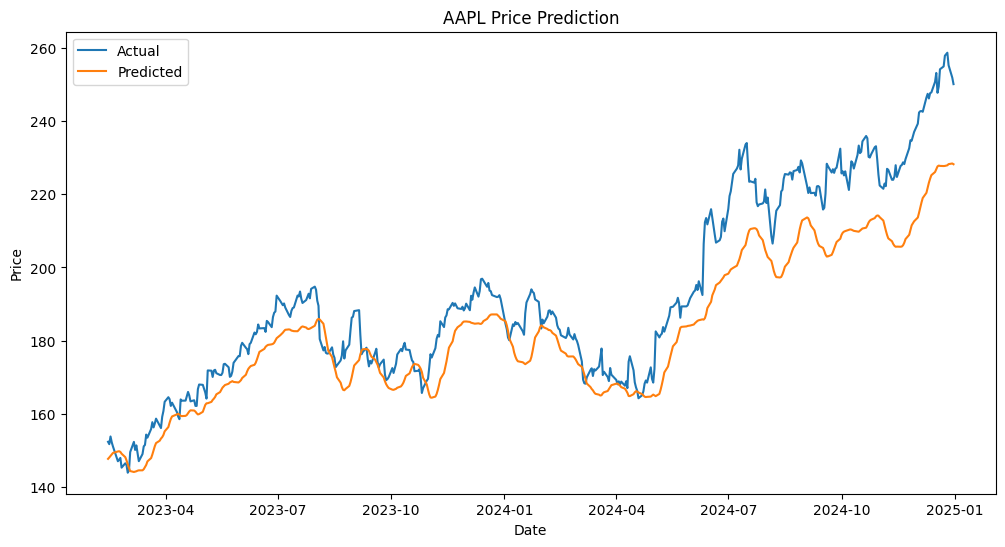

In [9]:
lstm_pred = model.predict(X_test)
# invert scaling for predictions
pad_zeros = lambda arr: np.concatenate([arr, np.zeros((arr.shape[0], len(features)-1))], axis=1)
inv_pred = scaler.inverse_transform(pad_zeros(lstm_pred))[:,0]
inv_true = scaler.inverse_transform(pad_zeros(y_test.reshape(-1,1)))[:,0]

mae_lstm  = mean_absolute_error(inv_true, inv_pred)
rmse_lstm = np.sqrt(mean_squared_error(inv_true, inv_pred))
print(f"LSTM MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12,6))
plt.plot(test_df.index[seq_length:], inv_true, label="Actual")
plt.plot(test_df.index[seq_length:], inv_pred, label="Predicted")
plt.title(f"{ticker} Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [10]:
def predict_next(data_df, model, scaler, features, seq_length=20):
    recent = data_df[features].values[-seq_length:]
    scaled = scaler.transform(recent)
    X_input = scaled.reshape(1, seq_length, len(features))
    pred_scaled = model.predict(X_input)
    inv = scaler.inverse_transform(np.concatenate([pred_scaled, np.zeros((1, len(features)-1))], axis=1))
    return inv[0,0]

next_price = predict_next(df, model, scaler, features, seq_length)
print("Next-day forecast:", next_price)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Next-day forecast: 227.7394638042588
